# Setup
(No need to change anything)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-cf8z2ngp
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-cf8z2ngp
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit ce82675a8e89b6d5e6229a89620c843c794f3b04
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.7 MB/s eta 0:00:00
    

In [2]:
# # Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
# import plotly.io as pio

# if IN_COLAB or not DEBUG_MODE:
#     # Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
#     pio.renderers.default = "colab"
# else:
#     pio.renderers.default = "png"

In [3]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [4]:
# import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [5]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [6]:
# def imshow(tensor, renderer=None, **kwargs):
#     px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

# def line(tensor, renderer=None, **kwargs):
#     px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

# def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
#     x = utils.to_numpy(x)
#     y = utils.to_numpy(y)
#     px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

## Load Model

In [7]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


## Import functions from repo

In [8]:
!git clone https://github.com/callummcdougall/ARENA_2.0.git

Cloning into 'ARENA_2.0'...
remote: Enumerating objects: 9262, done.
remote: Counting objects: 100% (1974/1974), done.
remote: Compressing objects: 100% (343/343), done.
remote: Total 9262 (delta 1725), reused 1731 (delta 1627), pack-reused 7288
Receiving objects: 100% (9262/9262), 156.79 MiB | 25.48 MiB/s, done.
Resolving deltas: 100% (5620/5620), done.


In [9]:
cd ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification

/content/ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification


In [10]:
import ioi_circuit_extraction as ioi_circuit_extraction

# Generate dataset with multiple prompts

In [11]:
class Dataset:
    def __init__(self, prompts, pos_dict, tokenizer, S1_is_first=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        # all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.ioi_prompts]
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.io_tokenIDs = [
            self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
        ]
        self.s_tokenIDs = [
            self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
        ]

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = model.tokenizer.tokenize(input_text)
                # if S1_is_first and targ == "S1":  # only use this if first token doesn't have space Ġ in front
                #     target_token = prompt[targ]
                # else:
                #     target_token = "Ġ" + prompt[targ]
                # target_index = tokens.index(target_token)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

In [12]:
pos_dict = {
    'S1': 0,
    'S2': 1,
    'S3': 2,
    'S4': 3,
}

In [13]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i+1),
            'S3': str(i+2),
            'S4': str(i+3),
            'corr': str(i+4),
            'incorr': str(i+3),
            'text': f"{i} {i+1} {i+2} {i+3}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 101)
dataset = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)

In [14]:
# import random

# def generate_prompts_list_corr(x ,y):
#     prompts_list = []
#     for i in range(x, y):
#         r1 = random.randint(1, 100)
#         r2 = random.randint(1, 100)
#         while True:
#             r3 = random.randint(1, 100)
#             r4 = random.randint(1, 100)
#             if r4 - 1 != r3:
#                 break
#         prompt_dict = {
#             'S1': str(r1),
#             'S2': str(r2),
#             'S3': str(r3),
#             'S4': str(r4),
#             'corr': str(i+4),
#             'incorr': str(i+3),
#             'text': f"{r1} {r2} {r3} {r4}"
#         }
#         prompts_list.append(prompt_dict)
#     return prompts_list

# prompts_list_2 = generate_prompts_list_corr(1, 101)
# dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)
# prompts_list_2

In [15]:
prompts_list_2 = [{'S1': '57',
  'S2': '28',
  'S3': '27',
  'S4': '97',
  'corr': '5',
  'incorr': '4',
  'text': '57 28 27 97'},
 {'S1': '33',
  'S2': '16',
  'S3': '94',
  'S4': '24',
  'corr': '6',
  'incorr': '5',
  'text': '33 16 94 24'},
 {'S1': '63',
  'S2': '98',
  'S3': '42',
  'S4': '94',
  'corr': '7',
  'incorr': '6',
  'text': '63 98 42 94'},
 {'S1': '7',
  'S2': '21',
  'S3': '48',
  'S4': '81',
  'corr': '8',
  'incorr': '7',
  'text': '7 21 48 81'},
 {'S1': '63',
  'S2': '93',
  'S3': '44',
  'S4': '25',
  'corr': '9',
  'incorr': '8',
  'text': '63 93 44 25'},
 {'S1': '47',
  'S2': '70',
  'S3': '69',
  'S4': '71',
  'corr': '10',
  'incorr': '9',
  'text': '47 70 69 71'},
 {'S1': '11',
  'S2': '65',
  'S3': '41',
  'S4': '54',
  'corr': '11',
  'incorr': '10',
  'text': '11 65 41 54'},
 {'S1': '47',
  'S2': '25',
  'S3': '25',
  'S4': '86',
  'corr': '12',
  'incorr': '11',
  'text': '47 25 25 86'},
 {'S1': '26',
  'S2': '90',
  'S3': '11',
  'S4': '17',
  'corr': '13',
  'incorr': '12',
  'text': '26 90 11 17'},
 {'S1': '84',
  'S2': '49',
  'S3': '76',
  'S4': '37',
  'corr': '14',
  'incorr': '13',
  'text': '84 49 76 37'},
 {'S1': '56',
  'S2': '58',
  'S3': '41',
  'S4': '21',
  'corr': '15',
  'incorr': '14',
  'text': '56 58 41 21'},
 {'S1': '5',
  'S2': '35',
  'S3': '45',
  'S4': '99',
  'corr': '16',
  'incorr': '15',
  'text': '5 35 45 99'},
 {'S1': '47',
  'S2': '93',
  'S3': '75',
  'S4': '94',
  'corr': '17',
  'incorr': '16',
  'text': '47 93 75 94'},
 {'S1': '4',
  'S2': '52',
  'S3': '65',
  'S4': '95',
  'corr': '18',
  'incorr': '17',
  'text': '4 52 65 95'},
 {'S1': '14',
  'S2': '24',
  'S3': '31',
  'S4': '2',
  'corr': '19',
  'incorr': '18',
  'text': '14 24 31 2'},
 {'S1': '4',
  'S2': '83',
  'S3': '51',
  'S4': '11',
  'corr': '20',
  'incorr': '19',
  'text': '4 83 51 11'},
 {'S1': '78',
  'S2': '91',
  'S3': '81',
  'S4': '60',
  'corr': '21',
  'incorr': '20',
  'text': '78 91 81 60'},
 {'S1': '95',
  'S2': '2',
  'S3': '44',
  'S4': '52',
  'corr': '22',
  'incorr': '21',
  'text': '95 2 44 52'},
 {'S1': '44',
  'S2': '39',
  'S3': '26',
  'S4': '69',
  'corr': '23',
  'incorr': '22',
  'text': '44 39 26 69'},
 {'S1': '12',
  'S2': '85',
  'S3': '53',
  'S4': '26',
  'corr': '24',
  'incorr': '23',
  'text': '12 85 53 26'},
 {'S1': '50',
  'S2': '99',
  'S3': '80',
  'S4': '95',
  'corr': '25',
  'incorr': '24',
  'text': '50 99 80 95'},
 {'S1': '63',
  'S2': '68',
  'S3': '34',
  'S4': '21',
  'corr': '26',
  'incorr': '25',
  'text': '63 68 34 21'},
 {'S1': '93',
  'S2': '48',
  'S3': '21',
  'S4': '71',
  'corr': '27',
  'incorr': '26',
  'text': '93 48 21 71'},
 {'S1': '33',
  'S2': '89',
  'S3': '72',
  'S4': '11',
  'corr': '28',
  'incorr': '27',
  'text': '33 89 72 11'},
 {'S1': '9',
  'S2': '41',
  'S3': '74',
  'S4': '34',
  'corr': '29',
  'incorr': '28',
  'text': '9 41 74 34'},
 {'S1': '89',
  'S2': '76',
  'S3': '66',
  'S4': '35',
  'corr': '30',
  'incorr': '29',
  'text': '89 76 66 35'},
 {'S1': '43',
  'S2': '48',
  'S3': '6',
  'S4': '26',
  'corr': '31',
  'incorr': '30',
  'text': '43 48 6 26'},
 {'S1': '51',
  'S2': '71',
  'S3': '19',
  'S4': '77',
  'corr': '32',
  'incorr': '31',
  'text': '51 71 19 77'},
 {'S1': '23',
  'S2': '46',
  'S3': '2',
  'S4': '68',
  'corr': '33',
  'incorr': '32',
  'text': '23 46 2 68'},
 {'S1': '59',
  'S2': '67',
  'S3': '82',
  'S4': '58',
  'corr': '34',
  'incorr': '33',
  'text': '59 67 82 58'},
 {'S1': '49',
  'S2': '60',
  'S3': '20',
  'S4': '7',
  'corr': '35',
  'incorr': '34',
  'text': '49 60 20 7'},
 {'S1': '76',
  'S2': '45',
  'S3': '91',
  'S4': '29',
  'corr': '36',
  'incorr': '35',
  'text': '76 45 91 29'},
 {'S1': '62',
  'S2': '6',
  'S3': '96',
  'S4': '60',
  'corr': '37',
  'incorr': '36',
  'text': '62 6 96 60'},
 {'S1': '82',
  'S2': '92',
  'S3': '2',
  'S4': '32',
  'corr': '38',
  'incorr': '37',
  'text': '82 92 2 32'},
 {'S1': '84',
  'S2': '10',
  'S3': '3',
  'S4': '21',
  'corr': '39',
  'incorr': '38',
  'text': '84 10 3 21'},
 {'S1': '77',
  'S2': '27',
  'S3': '52',
  'S4': '5',
  'corr': '40',
  'incorr': '39',
  'text': '77 27 52 5'},
 {'S1': '72',
  'S2': '86',
  'S3': '38',
  'S4': '15',
  'corr': '41',
  'incorr': '40',
  'text': '72 86 38 15'},
 {'S1': '76',
  'S2': '39',
  'S3': '51',
  'S4': '18',
  'corr': '42',
  'incorr': '41',
  'text': '76 39 51 18'},
 {'S1': '66',
  'S2': '35',
  'S3': '59',
  'S4': '61',
  'corr': '43',
  'incorr': '42',
  'text': '66 35 59 61'},
 {'S1': '12',
  'S2': '32',
  'S3': '97',
  'S4': '24',
  'corr': '44',
  'incorr': '43',
  'text': '12 32 97 24'},
 {'S1': '49',
  'S2': '21',
  'S3': '5',
  'S4': '77',
  'corr': '45',
  'incorr': '44',
  'text': '49 21 5 77'},
 {'S1': '89',
  'S2': '58',
  'S3': '58',
  'S4': '6',
  'corr': '46',
  'incorr': '45',
  'text': '89 58 58 6'},
 {'S1': '82',
  'S2': '99',
  'S3': '15',
  'S4': '9',
  'corr': '47',
  'incorr': '46',
  'text': '82 99 15 9'},
 {'S1': '100',
  'S2': '28',
  'S3': '30',
  'S4': '92',
  'corr': '48',
  'incorr': '47',
  'text': '100 28 30 92'},
 {'S1': '76',
  'S2': '66',
  'S3': '64',
  'S4': '71',
  'corr': '49',
  'incorr': '48',
  'text': '76 66 64 71'},
 {'S1': '69',
  'S2': '22',
  'S3': '49',
  'S4': '21',
  'corr': '50',
  'incorr': '49',
  'text': '69 22 49 21'},
 {'S1': '54',
  'S2': '27',
  'S3': '86',
  'S4': '64',
  'corr': '51',
  'incorr': '50',
  'text': '54 27 86 64'},
 {'S1': '12',
  'S2': '52',
  'S3': '10',
  'S4': '53',
  'corr': '52',
  'incorr': '51',
  'text': '12 52 10 53'},
 {'S1': '84',
  'S2': '74',
  'S3': '87',
  'S4': '2',
  'corr': '53',
  'incorr': '52',
  'text': '84 74 87 2'},
 {'S1': '58',
  'S2': '6',
  'S3': '21',
  'S4': '99',
  'corr': '54',
  'incorr': '53',
  'text': '58 6 21 99'},
 {'S1': '32',
  'S2': '9',
  'S3': '60',
  'S4': '20',
  'corr': '55',
  'incorr': '54',
  'text': '32 9 60 20'},
 {'S1': '18',
  'S2': '8',
  'S3': '81',
  'S4': '27',
  'corr': '56',
  'incorr': '55',
  'text': '18 8 81 27'},
 {'S1': '98',
  'S2': '72',
  'S3': '10',
  'S4': '70',
  'corr': '57',
  'incorr': '56',
  'text': '98 72 10 70'},
 {'S1': '65',
  'S2': '19',
  'S3': '49',
  'S4': '35',
  'corr': '58',
  'incorr': '57',
  'text': '65 19 49 35'},
 {'S1': '25',
  'S2': '49',
  'S3': '55',
  'S4': '59',
  'corr': '59',
  'incorr': '58',
  'text': '25 49 55 59'},
 {'S1': '21',
  'S2': '87',
  'S3': '20',
  'S4': '34',
  'corr': '60',
  'incorr': '59',
  'text': '21 87 20 34'},
 {'S1': '10',
  'S2': '6',
  'S3': '19',
  'S4': '6',
  'corr': '61',
  'incorr': '60',
  'text': '10 6 19 6'},
 {'S1': '37',
  'S2': '54',
  'S3': '89',
  'S4': '51',
  'corr': '62',
  'incorr': '61',
  'text': '37 54 89 51'},
 {'S1': '44',
  'S2': '99',
  'S3': '42',
  'S4': '91',
  'corr': '63',
  'incorr': '62',
  'text': '44 99 42 91'},
 {'S1': '17',
  'S2': '37',
  'S3': '50',
  'S4': '2',
  'corr': '64',
  'incorr': '63',
  'text': '17 37 50 2'},
 {'S1': '35',
  'S2': '88',
  'S3': '52',
  'S4': '45',
  'corr': '65',
  'incorr': '64',
  'text': '35 88 52 45'},
 {'S1': '15',
  'S2': '17',
  'S3': '82',
  'S4': '29',
  'corr': '66',
  'incorr': '65',
  'text': '15 17 82 29'},
 {'S1': '15',
  'S2': '96',
  'S3': '90',
  'S4': '89',
  'corr': '67',
  'incorr': '66',
  'text': '15 96 90 89'},
 {'S1': '6',
  'S2': '12',
  'S3': '51',
  'S4': '36',
  'corr': '68',
  'incorr': '67',
  'text': '6 12 51 36'},
 {'S1': '100',
  'S2': '3',
  'S3': '5',
  'S4': '54',
  'corr': '69',
  'incorr': '68',
  'text': '100 3 5 54'},
 {'S1': '33',
  'S2': '86',
  'S3': '35',
  'S4': '77',
  'corr': '70',
  'incorr': '69',
  'text': '33 86 35 77'},
 {'S1': '4',
  'S2': '50',
  'S3': '44',
  'S4': '38',
  'corr': '71',
  'incorr': '70',
  'text': '4 50 44 38'},
 {'S1': '70',
  'S2': '88',
  'S3': '30',
  'S4': '35',
  'corr': '72',
  'incorr': '71',
  'text': '70 88 30 35'},
 {'S1': '7',
  'S2': '87',
  'S3': '53',
  'S4': '88',
  'corr': '73',
  'incorr': '72',
  'text': '7 87 53 88'},
 {'S1': '34',
  'S2': '64',
  'S3': '38',
  'S4': '84',
  'corr': '74',
  'incorr': '73',
  'text': '34 64 38 84'},
 {'S1': '8',
  'S2': '97',
  'S3': '85',
  'S4': '97',
  'corr': '75',
  'incorr': '74',
  'text': '8 97 85 97'},
 {'S1': '2',
  'S2': '5',
  'S3': '61',
  'S4': '28',
  'corr': '76',
  'incorr': '75',
  'text': '2 5 61 28'},
 {'S1': '56',
  'S2': '94',
  'S3': '32',
  'S4': '88',
  'corr': '77',
  'incorr': '76',
  'text': '56 94 32 88'},
 {'S1': '14',
  'S2': '97',
  'S3': '55',
  'S4': '87',
  'corr': '78',
  'incorr': '77',
  'text': '14 97 55 87'},
 {'S1': '93',
  'S2': '36',
  'S3': '38',
  'S4': '4',
  'corr': '79',
  'incorr': '78',
  'text': '93 36 38 4'},
 {'S1': '79',
  'S2': '94',
  'S3': '43',
  'S4': '82',
  'corr': '80',
  'incorr': '79',
  'text': '79 94 43 82'},
 {'S1': '23',
  'S2': '55',
  'S3': '12',
  'S4': '81',
  'corr': '81',
  'incorr': '80',
  'text': '23 55 12 81'},
 {'S1': '65',
  'S2': '1',
  'S3': '25',
  'S4': '94',
  'corr': '82',
  'incorr': '81',
  'text': '65 1 25 94'},
 {'S1': '93',
  'S2': '28',
  'S3': '80',
  'S4': '65',
  'corr': '83',
  'incorr': '82',
  'text': '93 28 80 65'},
 {'S1': '21',
  'S2': '8',
  'S3': '69',
  'S4': '87',
  'corr': '84',
  'incorr': '83',
  'text': '21 8 69 87'},
 {'S1': '70',
  'S2': '5',
  'S3': '29',
  'S4': '77',
  'corr': '85',
  'incorr': '84',
  'text': '70 5 29 77'},
 {'S1': '26',
  'S2': '43',
  'S3': '67',
  'S4': '48',
  'corr': '86',
  'incorr': '85',
  'text': '26 43 67 48'},
 {'S1': '67',
  'S2': '1',
  'S3': '53',
  'S4': '69',
  'corr': '87',
  'incorr': '86',
  'text': '67 1 53 69'},
 {'S1': '63',
  'S2': '22',
  'S3': '87',
  'S4': '33',
  'corr': '88',
  'incorr': '87',
  'text': '63 22 87 33'},
 {'S1': '59',
  'S2': '2',
  'S3': '97',
  'S4': '69',
  'corr': '89',
  'incorr': '88',
  'text': '59 2 97 69'},
 {'S1': '44',
  'S2': '66',
  'S3': '19',
  'S4': '52',
  'corr': '90',
  'incorr': '89',
  'text': '44 66 19 52'},
 {'S1': '78',
  'S2': '52',
  'S3': '57',
  'S4': '38',
  'corr': '91',
  'incorr': '90',
  'text': '78 52 57 38'},
 {'S1': '58',
  'S2': '93',
  'S3': '99',
  'S4': '37',
  'corr': '92',
  'incorr': '91',
  'text': '58 93 99 37'},
 {'S1': '87',
  'S2': '44',
  'S3': '40',
  'S4': '13',
  'corr': '93',
  'incorr': '92',
  'text': '87 44 40 13'},
 {'S1': '13',
  'S2': '35',
  'S3': '92',
  'S4': '10',
  'corr': '94',
  'incorr': '93',
  'text': '13 35 92 10'},
 {'S1': '99',
  'S2': '39',
  'S3': '69',
  'S4': '30',
  'corr': '95',
  'incorr': '94',
  'text': '99 39 69 30'},
 {'S1': '55',
  'S2': '47',
  'S3': '89',
  'S4': '100',
  'corr': '96',
  'incorr': '95',
  'text': '55 47 89 100'},
 {'S1': '78',
  'S2': '2',
  'S3': '43',
  'S4': '4',
  'corr': '97',
  'incorr': '96',
  'text': '78 2 43 4'},
 {'S1': '66',
  'S2': '3',
  'S3': '94',
  'S4': '70',
  'corr': '98',
  'incorr': '97',
  'text': '66 3 94 70'},
 {'S1': '65',
  'S2': '22',
  'S3': '44',
  'S4': '65',
  'corr': '99',
  'incorr': '98',
  'text': '65 22 44 65'},
 {'S1': '60',
  'S2': '8',
  'S3': '1',
  'S4': '4',
  'corr': '100',
  'incorr': '99',
  'text': '60 8 1 4'},
 {'S1': '40',
  'S2': '31',
  'S3': '16',
  'S4': '65',
  'corr': '101',
  'incorr': '100',
  'text': '40 31 16 65'},
 {'S1': '8',
  'S2': '10',
  'S3': '71',
  'S4': '92',
  'corr': '102',
  'incorr': '101',
  'text': '8 10 71 92'},
 {'S1': '10',
  'S2': '47',
  'S3': '3',
  'S4': '14',
  'corr': '103',
  'incorr': '102',
  'text': '10 47 3 14'},
 {'S1': '50',
  'S2': '12',
  'S3': '44',
  'S4': '11',
  'corr': '104',
  'incorr': '103',
  'text': '50 12 44 11'}]

In [16]:
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)

# Ablation Expm Functions

In [17]:
from torch import Tensor

def logits_to_ave_logit_diff_2(logits: Float[Tensor, "batch seq d_vocab"], dataset: Dataset, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    io_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.io_tokenIDs]
    s_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.s_tokenIDs]
    # Find logit difference
    answer_logit_diff = io_logits - s_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

In [18]:
model.reset_hooks(including_permanent=True)
ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)
orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)

In [19]:
def mean_ablate_by_lst(lst, model, orig_score, print_output=True):
    CIRCUIT = {
        "number mover": lst,
        # "number mover 4": lst,
        "number mover 3": lst,
        "number mover 2": lst,
        "number mover 1": lst,
    }

    SEQ_POS_TO_KEEP = {
        "number mover": "end",
        # "number mover 4": "S4",
        "number mover 3": "S3",
        "number mover 2": "S2",
        "number mover 1": "S1",
    }

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    # ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

    model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    ioi_logits_minimal = model(dataset.toks)

    # orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)
    new_score = logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset)
    if print_output:
        # print(f"Average logit difference (IOI dataset, using entire model): {orig_score:.4f}")
        # print(f"Average logit difference (IOI dataset, only using circuit): {new_score:.4f}")
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    # return new_score
    return 100 * new_score / orig_score

In [20]:
def find_circuit_forw(curr_circuit=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    if curr_circuit == []:
        # Start with full circuit
        curr_circuit = [(layer, head) for layer in range(12) for head in range(12)]

    for layer in range(0, 12):
        for head in range(12):
            if (layer, head) not in curr_circuit:
                continue

            # Copying the curr_circuit so we can iterate over one and modify the other
            copy_circuit = curr_circuit.copy()

            # Temporarily removing the current tuple from the copied circuit
            copy_circuit.remove((layer, head))

            new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=False).item()

            # print((layer,head), new_score)
            # If the result is less than the threshold, remove the tuple from the original list
            if (100 - new_score) < threshold:
                curr_circuit.remove((layer, head))

                print("\nRemoved:", (layer, head))
                print(new_score)

    return curr_circuit, new_score

In [21]:
def find_circuit_backw(curr_circuit=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    if curr_circuit == []:
        # Start with full circuit
        curr_circuit = [(layer, head) for layer in range(12) for head in range(12)]

    for layer in range(11, -1, -1):  # go thru all heads in a layer first
        for head in range(12):
            if (layer, head) not in curr_circuit:
                continue

            # Copying the curr_circuit so we can iterate over one and modify the other
            copy_circuit = curr_circuit.copy()

            # Temporarily removing the current tuple from the copied circuit
            copy_circuit.remove((layer, head))

            new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=False).item()

            # If the result is less than the threshold, remove the tuple from the original list
            if (100 - new_score) < threshold:
                curr_circuit.remove((layer, head))

                print("\nRemoved:", (layer, head))
                print(new_score)

    return curr_circuit, new_score

# rmv most impt heads from full

In [22]:
circ = [(layer, head) for layer in range(12) for head in range(12)]
lh_scores = {}
for lh in circ:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 0)
Average logit difference (circuit / full) %: 99.5731
removed: (0, 1)
Average logit difference (circuit / full) %: 95.3242
removed: (0, 2)
Average logit difference (circuit / full) %: 95.9500
removed: (0, 3)
Average logit difference (circuit / full) %: 100.4164
removed: (0, 4)
Average logit difference (circuit / full) %: 100.3200
removed: (0, 5)
Average logit difference (circuit / full) %: 98.9746
removed: (0, 6)
Average logit difference (circuit / full) %: 101.2787
removed: (0, 7)
Average logit difference (circuit / full) %: 98.3887
removed: (0, 8)
Average logit difference (circuit / full) %: 99.3132
removed: (0, 9)
Average logit difference (circuit / full) %: 98.6615
removed: (0, 10)
Average logit difference (circuit / full) %: 90.4121
removed: (0, 11)
Average logit difference (circuit / full) %: 100.0939
removed: (1, 0)
Average logit difference (circuit / full) %: 96.5085
removed: (1, 1)
Average logit difference (circuit / full) %: 99.5392
removed: (1, 2)
Average logi

In [25]:
# Sort the dictionary by values in descending order
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True))

# Select the top 10 items
top_10_lh_scores = dict(list(sorted_lh_scores.items())[:10])
top_10_lh_scores

{(4, 4): 30.71341323852539,
 (1, 5): 74.1940689086914,
 (9, 1): 83.33995819091797,
 (5, 8): 85.49739837646484,
 (7, 11): 86.55789947509766,
 (10, 7): 89.46626281738281,
 (0, 10): 90.41207122802734,
 (6, 10): 92.28072357177734,
 (8, 6): 93.87860107421875,
 (8, 0): 94.33844757080078}

In [29]:
# for lh, score in sorted_lh_scores.items():
#     print(lh, -round(100-score, 2))

# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
for lh, score in sorted_lh_scores[:10]:
    modified_score = -round(100 - score, 2)
    print(lh, modified_score)

(4, 4) -69.29
(1, 5) -25.81
(9, 1) -16.66
(5, 8) -14.5
(7, 11) -13.44
(10, 7) -10.53
(0, 10) -9.59
(6, 10) -7.72
(8, 6) -6.12
(8, 0) -5.66


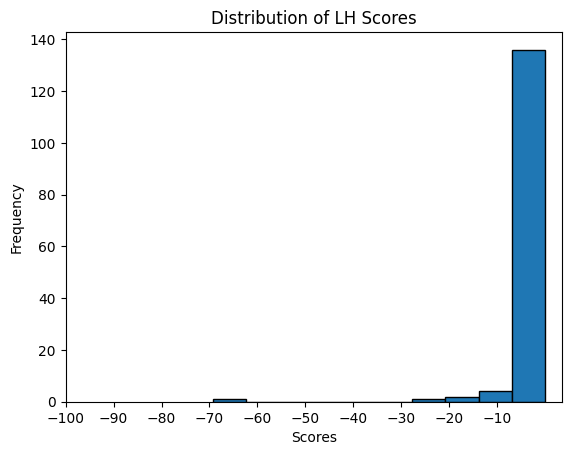

In [36]:
import matplotlib.pyplot as plt

lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}

# Extracting only the values (scores) from the dictionary
scores = list(lh_scores_drop.values())

# Creating a histogram for the scores
plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Setting x-axis ticks at intervals of 10 from 0 to 100
plt.xticks(range(-100, 0, 10))

# Adding labels and title for clarity
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of LH Scores')

# Displaying the plot
plt.show()

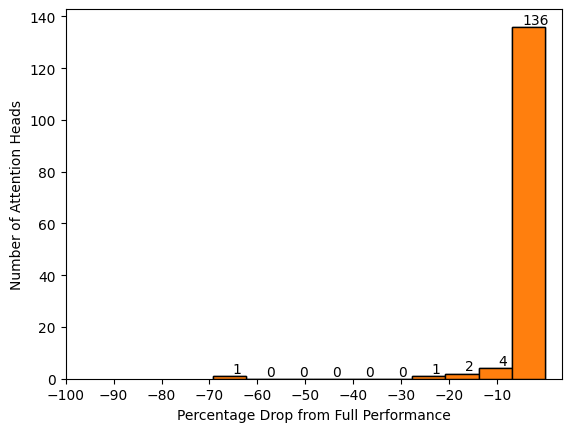

In [45]:
import matplotlib.pyplot as plt

lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}

# Extracting only the values (scores) from the dictionary
scores = list(lh_scores_drop.values())

# Creating a histogram for the scores
plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Creating a histogram for the scores
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

# Setting x-axis ticks at intervals of 10 from 0 to 100
plt.xticks(range(-100, 0, 10))

# Adding labels and title for clarity
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# Displaying the plot
plt.show()

In [47]:
from google.colab import files

pdf_filename = 'lh_scores_distribution.png'
plt.savefig(pdf_filename)

# Download the file in Colab
files.download(pdf_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

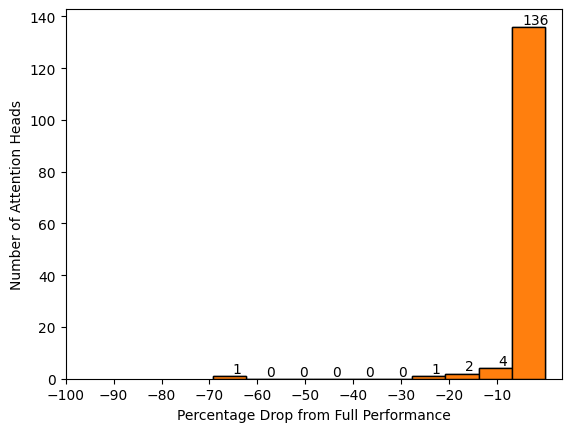

In [49]:
from google.colab import files

lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}

# Extracting only the values (scores) from the dictionary
scores = list(lh_scores_drop.values())

# Creating a histogram for the scores
plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Creating a histogram for the scores
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

# Setting x-axis ticks at intervals of 10 from 0 to 100
plt.xticks(range(-100, 0, 10))

# Adding labels and title for clarity
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# Displaying the plot
# plt.show()

# Save the figure
pdf_filename = 'lh_scores_distribution.pdf'
plt.savefig(pdf_filename)

# Download the file in Colab
files.download(pdf_filename)

In [50]:
import statistics

# Assuming lh_scores_drop is already defined
# For example, lh_scores_drop = {key: max(0, 100 - val) for key, val in lh_scores.items()}

# Extracting the values from the dictionary
scores = list(lh_scores_drop.values())

# Calculating the mean
mean_score = statistics.mean(scores)

print("Mean of the scores:", mean_score)


Mean of the scores: -1.9447844558291965


In [38]:
def get_probability_ranking(value, distribution):
    # Convert distribution to a probability distribution (if not already)
    total = sum(distribution)
    prob_distribution = [x / total for x in distribution]

    # Sort the probability distribution
    sorted_distribution = sorted(prob_distribution)

    # Calculate the cumulative probability up to the given value
    cumulative_prob = sum(prob for prob in sorted_distribution if prob <= value)

    return cumulative_prob

# Example usage
distribution = lh_scores_drop.values()
value = -0.69  # Value to get the probability ranking for
ranking = get_probability_ranking(value, distribution)
print(f"Probability Ranking of {value} in the distribution: {ranking}")


Probability Ranking of -0.69 in the distribution: 0


# iter backw fwd, threshold 3

In [ ]:
threshold = 3
curr_circuit = []
prev_score = 100
new_score = 0
iter = 1
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    # prev_score = new_score # save old score before finding new one
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_backw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_forw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    iter += 1


backw prune, iter  1

Removed: (11, 0)
98.31387329101562

Removed: (11, 1)
98.42906188964844

Removed: (11, 2)
99.06758117675781

Removed: (11, 3)
99.34346008300781

Removed: (11, 4)
99.74256896972656

Removed: (11, 5)
99.83814239501953

Removed: (11, 6)
100.08563995361328

Removed: (11, 7)
100.06522369384766

Removed: (11, 8)
97.51736450195312

Removed: (11, 9)
97.63125610351562

Removed: (11, 11)
100.11857604980469

Removed: (10, 0)
100.43421173095703

Removed: (10, 1)
100.5700454711914

Removed: (10, 2)
106.46180725097656

Removed: (10, 3)
106.58599090576172

Removed: (10, 4)
106.59420776367188

Removed: (10, 5)
106.63070678710938

Removed: (10, 6)
106.78192901611328

Removed: (10, 8)
106.79447937011719

Removed: (10, 9)
106.88640594482422

Removed: (10, 10)
107.2558822631836

Removed: (10, 11)
107.446533203125

Removed: (9, 0)
107.47273254394531

Removed: (9, 2)
107.51925659179688

Removed: (9, 3)
106.568603515625

Removed: (9, 4)
105.48066711425781

Removed: (9, 5)
101.2692184448

In [ ]:
bf_3 = curr_circuit.copy()
bf_3

[(0, 1),
 (0, 2),
 (0, 5),
 (0, 7),
 (0, 8),
 (0, 10),
 (1, 0),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 11),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 5),
 (2, 6),
 (2, 8),
 (2, 9),
 (2, 10),
 (3, 3),
 (3, 7),
 (3, 8),
 (3, 10),
 (3, 11),
 (4, 2),
 (4, 4),
 (4, 6),
 (4, 10),
 (4, 11),
 (5, 1),
 (5, 4),
 (5, 8),
 (5, 10),
 (5, 11),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (7, 11),
 (8, 6),
 (8, 8),
 (9, 1),
 (10, 7),
 (11, 10)]

In [ ]:
len(bf_3)

51

## loop rmv and check for most impt heads

In [ ]:
circ = bf_3
circ_score = mean_ablate_by_lst(circ, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 97.1835


In [ ]:
lh_scores = {}
for lh in circ:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 1)
Average logit difference (circuit / full) %: 88.1980
removed: (0, 2)
Average logit difference (circuit / full) %: 92.8093
removed: (0, 5)
Average logit difference (circuit / full) %: 95.9845
removed: (0, 7)
Average logit difference (circuit / full) %: 95.3316
removed: (0, 8)
Average logit difference (circuit / full) %: 95.7508
removed: (0, 10)
Average logit difference (circuit / full) %: 95.3977
removed: (1, 0)
Average logit difference (circuit / full) %: 93.9189
removed: (1, 1)
Average logit difference (circuit / full) %: 95.6137
removed: (1, 3)
Average logit difference (circuit / full) %: 96.7553
removed: (1, 5)
Average logit difference (circuit / full) %: 71.9611
removed: (1, 7)
Average logit difference (circuit / full) %: 96.6990
removed: (1, 11)
Average logit difference (circuit / full) %: 78.8032
removed: (2, 0)
Average logit difference (circuit / full) %: 96.1898
removed: (2, 1)
Average logit difference (circuit / full) %: 95.0143
removed: (2, 2)
Average logit di

In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
sorted_lh_scores

{(4, 4): 29.947500228881836,
 (9, 1): 49.95400619506836,
 (7, 11): 68.10021209716797,
 (1, 5): 71.9610595703125,
 (1, 11): 78.80315399169922,
 (6, 10): 83.47547149658203,
 (5, 8): 87.68802642822266,
 (0, 1): 88.19804382324219,
 (8, 6): 88.94493103027344,
 (5, 1): 91.7568130493164,
 (5, 4): 91.88407135009766,
 (0, 2): 92.8093032836914,
 (4, 10): 92.8308334350586,
 (4, 11): 92.98267364501953,
 (2, 2): 93.00918579101562,
 (3, 3): 93.04792022705078,
 (10, 7): 93.56689453125,
 (6, 6): 93.78317260742188,
 (6, 3): 93.85193634033203,
 (1, 0): 93.91886138916016,
 (3, 7): 94.14549255371094,
 (6, 8): 94.27928161621094,
 (2, 6): 94.8059310913086,
 (5, 11): 94.82439422607422,
 (2, 1): 95.0142593383789,
 (0, 7): 95.33157348632812,
 (8, 8): 95.3754653930664,
 (0, 10): 95.39774322509766,
 (6, 9): 95.59938049316406,
 (1, 1): 95.61369323730469,
 (0, 8): 95.75081634521484,
 (4, 6): 95.76248168945312,
 (2, 3): 95.7677001953125,
 (3, 11): 95.85832214355469,
 (0, 5): 95.9845199584961,
 (3, 8): 95.9927978515

In [ ]:
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score, 2))

(4, 4) -67.24
(9, 1) -47.23
(7, 11) -29.08
(1, 5) -25.22
(1, 11) -18.38
(6, 10) -13.71
(5, 8) -9.5
(0, 1) -8.99
(8, 6) -8.24
(5, 1) -5.43
(5, 4) -5.3
(0, 2) -4.37
(4, 10) -4.35
(4, 11) -4.2
(2, 2) -4.17
(3, 3) -4.14
(10, 7) -3.62
(6, 6) -3.4
(6, 3) -3.33
(1, 0) -3.26
(3, 7) -3.04
(6, 8) -2.9
(2, 6) -2.38
(5, 11) -2.36
(2, 1) -2.17
(0, 7) -1.85
(8, 8) -1.81
(0, 10) -1.79
(6, 9) -1.58
(1, 1) -1.57
(0, 8) -1.43
(4, 6) -1.42
(2, 3) -1.42
(3, 11) -1.33
(0, 5) -1.2
(3, 8) -1.19
(2, 9) -1.12
(2, 8) -1.05
(6, 11) -1.01
(2, 0) -0.99
(6, 2) -0.99
(6, 7) -0.95
(2, 10) -0.73
(5, 10) -0.62
(11, 10) -0.59
(2, 5) -0.52
(1, 7) -0.48
(6, 4) -0.45
(1, 3) -0.43
(4, 2) -0.4
(3, 10) -0.34


## try other tasks circs

### gt, IOI

In [ ]:
# greater-than
circuit = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: -1.8392


-1.8392001390457153

In [ ]:
# IOI
circuit = [(0, 1), (0, 10), (2, 2), (3, 0), (4, 11), (5, 5), (5, 8), (5, 9), (6, 9), (7, 3), (7, 9), (8, 6), (8, 10), (9, 0), (9, 6), (9, 7), (9, 9), (10, 0), (10, 1), (10, 2), (10, 6), (10, 7), (10, 10), (11, 2), (11, 9), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: -4.7977


-4.797651290893555

### bf 80

In [ ]:
# # fb 80, digits incr
# # https://colab.research.google.com/drive/1mFWmGAKtigFcqqWWMCwU7wWQY2HT5ZOo#scrollTo=lJEY-Zs2g_a5&line=1&uniqifier=1
# circuit = [(1, 5), (3, 3), (3, 7), (3, 10), (3, 11), (4, 4), (4, 6), (4, 7), (4, 10), (4, 11), (5, 0), (5, 2), (5, 3), (5, 4), (5, 6), (6, 3), (6, 8), (6, 10), (7, 0), (7, 2), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (11, 8)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, numwords
# # https://colab.research.google.com/drive/1QTv-4osLHadCAay0beew-xlXszPCG88s#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(3, 2), (4, 4), (4, 8), (4, 10), (4, 11), (5, 5), (5, 6), (5, 7), (5, 8), (6, 1), (6, 7), (6, 9), (6, 10), (7, 0), (7, 2), (7, 5), (7, 6), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 11), (9, 1), (10, 2)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, months
# # https://colab.research.google.com/drive/1lhQqlizYGMC11vzp6I9mJ3dyxIr8tV3l#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(4, 4), (7, 11), (8, 6), (8, 9), (8, 11), (9, 1), (9, 5), (11, 10)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

### bf 97

In [ ]:
# digits incr
# incorr i+3
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 3), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 5), (2, 6), (2, 8), (2, 9), (2, 10), (3, 3), (3, 7), (3, 8), (3, 10), (3, 11), (4, 2), (4, 4), (4, 6), (4, 10), (4, 11), (5, 1), (5, 4), (5, 8), (5, 10), (5, 11), (6, 2), (6, 3), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (8, 6), (8, 8), (9, 1), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 96.0624


96.06242370605469

In [ ]:
# numwords
# incorr i+3
circuit = [(0, 1), (0, 6), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (3, 3), (4, 4), (4, 10), (5, 4), (5, 6), (5, 8), (6, 6), (6, 10), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 52.9852


52.98516845703125

In [ ]:
# months
# incorr i
circuit = [(0, 1), (2, 3), (2, 5), (2, 7), (2, 8), (2, 9), (4, 4), (5, 0), (5, 6), (6, 9), (6, 10), (7, 8), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1), (9, 7), (9, 11), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 16.9102


16.910245895385742

# iter backw fwd, threshold 20

In [ ]:
threshold = 20
curr_circuit = []
prev_score = 100
new_score = 0
iter = 1
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    # prev_score = new_score # save old score before finding new one
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_backw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_forw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    iter += 1


backw prune, iter  1

Removed: (11, 0)
98.17157745361328

Removed: (11, 1)
98.30482482910156

Removed: (11, 2)
98.94801330566406

Removed: (11, 3)
99.21537780761719

Removed: (11, 4)
99.62644958496094

Removed: (11, 5)
99.71906280517578

Removed: (11, 6)
99.95066833496094

Removed: (11, 7)
99.92930603027344

Removed: (11, 8)
97.4985580444336

Removed: (11, 9)
97.60407257080078

Removed: (11, 10)
96.87455749511719

Removed: (11, 11)
99.38215637207031

Removed: (10, 0)
99.70042419433594

Removed: (10, 1)
99.85966491699219

Removed: (10, 2)
105.77660369873047

Removed: (10, 3)
105.93672180175781

Removed: (10, 4)
105.9847183227539

Removed: (10, 5)
106.06525421142578

Removed: (10, 6)
106.22776794433594

Removed: (10, 7)
95.98348999023438

Removed: (10, 8)
95.9676513671875

Removed: (10, 9)
96.08566284179688

Removed: (10, 10)
96.48067474365234

Removed: (10, 11)
96.66889190673828

Removed: (9, 0)
96.7402572631836

Removed: (9, 2)
96.81306457519531

Removed: (9, 3)
96.37824249267578

Rem

In [ ]:
bf_3 = curr_circuit.copy()
bf_3

[(0, 1),
 (0, 2),
 (0, 5),
 (0, 7),
 (0, 8),
 (0, 10),
 (1, 0),
 (1, 1),
 (1, 5),
 (1, 7),
 (1, 11),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 6),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 11),
 (4, 4),
 (4, 10),
 (5, 1),
 (5, 4),
 (5, 6),
 (5, 8),
 (5, 11),
 (6, 4),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (7, 11),
 (9, 1)]

In [ ]:
len(bf_3)

43

## loop rmv and check for most impt heads

In [ ]:
circ = bf_3
circ_score = mean_ablate_by_lst(circ, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 80.1949


In [ ]:
lh_scores = {}
for lh in circ:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 1)
Average logit difference (circuit / full) %: 69.3194
removed: (0, 2)
Average logit difference (circuit / full) %: 76.0551
removed: (0, 5)
Average logit difference (circuit / full) %: 78.5882
removed: (0, 7)
Average logit difference (circuit / full) %: 78.5450
removed: (0, 8)
Average logit difference (circuit / full) %: 78.7098
removed: (0, 10)
Average logit difference (circuit / full) %: 77.4205
removed: (1, 0)
Average logit difference (circuit / full) %: 76.9271
removed: (1, 1)
Average logit difference (circuit / full) %: 78.9167
removed: (1, 5)
Average logit difference (circuit / full) %: 54.7476
removed: (1, 7)
Average logit difference (circuit / full) %: 79.7013
removed: (1, 11)
Average logit difference (circuit / full) %: 57.7767
removed: (2, 0)
Average logit difference (circuit / full) %: 79.2179
removed: (2, 1)
Average logit difference (circuit / full) %: 78.3489
removed: (2, 2)
Average logit difference (circuit / full) %: 75.7510
removed: (2, 3)
Average logit di

In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
sorted_lh_scores

{(4, 4): 24.193449020385742,
 (9, 1): 33.44232940673828,
 (1, 5): 54.74757385253906,
 (7, 11): 55.586700439453125,
 (1, 11): 57.776695251464844,
 (6, 10): 67.89125061035156,
 (0, 1): 69.31940460205078,
 (5, 8): 72.69412231445312,
 (5, 4): 75.6282730102539,
 (2, 2): 75.75102996826172,
 (0, 2): 76.05513000488281,
 (6, 8): 76.28748321533203,
 (3, 3): 76.60326385498047,
 (4, 10): 76.60944366455078,
 (5, 6): 76.6446304321289,
 (1, 0): 76.92713928222656,
 (5, 1): 77.35383605957031,
 (0, 10): 77.42050170898438,
 (6, 6): 77.5040283203125,
 (5, 11): 77.66468048095703,
 (3, 7): 77.69738006591797,
 (6, 9): 77.81794738769531,
 (2, 6): 77.88691711425781,
 (2, 1): 78.3488998413086,
 (0, 7): 78.54499053955078,
 (0, 5): 78.58820343017578,
 (0, 8): 78.70977020263672,
 (1, 1): 78.91665649414062,
 (2, 10): 78.93745422363281,
 (3, 5): 78.9417495727539,
 (3, 4): 79.0721435546875,
 (3, 11): 79.1743392944336,
 (2, 3): 79.1996078491211,
 (2, 0): 79.21788024902344,
 (6, 7): 79.25686645507812,
 (2, 8): 79.31086

In [ ]:
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score, 2))

(4, 4) -56.0
(9, 1) -46.75
(1, 5) -25.45
(7, 11) -24.61
(1, 11) -22.42
(6, 10) -12.3
(0, 1) -10.88
(5, 8) -7.5
(5, 4) -4.57
(2, 2) -4.44
(0, 2) -4.14
(6, 8) -3.91
(3, 3) -3.59
(4, 10) -3.59
(5, 6) -3.55
(1, 0) -3.27
(5, 1) -2.84
(0, 10) -2.77
(6, 6) -2.69
(5, 11) -2.53
(3, 7) -2.5
(6, 9) -2.38
(2, 6) -2.31
(2, 1) -1.85
(0, 7) -1.65
(0, 5) -1.61
(0, 8) -1.49
(1, 1) -1.28
(2, 10) -1.26
(3, 5) -1.25
(3, 4) -1.12
(3, 11) -1.02
(2, 3) -1.0
(2, 0) -0.98
(6, 7) -0.94
(2, 8) -0.88
(6, 11) -0.83
(2, 9) -0.82
(3, 9) -0.51
(1, 7) -0.49
(3, 8) -0.48
(6, 4) -0.37
(2, 11) -0.25


## try other tasks circs

### bf 80

In [ ]:
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 6), (2, 8), (2, 9), (2, 10), (2, 11), (3, 3), (3, 4), (3, 5), (3, 7), (3, 8), (3, 9), (3, 11), (4, 4), (4, 10), (5, 1), (5, 4), (5, 6), (5, 8), (5, 11), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 80.1949


80.19486236572266

In [ ]:
# numwords
circuit = [(0, 1), (0, 9), (0, 10), (1, 5), (4, 4), (4, 7), (5, 6), (5, 8), (6, 1), (6, 6), (6, 10), (7, 5), (7, 6), (7, 10), (7, 11), (8, 7), (8, 8), (8, 10), (8, 11), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 35.1025


35.10247802734375

In [ ]:
# months
circuit = [(0, 1), (2, 2), (2, 9), (4, 4), (5, 0), (5, 1), (5, 4), (5, 6), (6, 6), (6, 9), (6, 10), (7, 7), (7, 11), (8, 8), (8, 9), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 16.2307


16.230731964111328

# try again using incorr logit i

In [ ]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i+1),
            'S3': str(i+2),
            'S4': str(i+3),
            'corr': str(i+4),
            'incorr': str(i),
            'text': f"{i} {i+1} {i+2} {i+3}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 101)
dataset = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)

In [ ]:
model.reset_hooks(including_permanent=True)
ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)
orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)

## iter backw fwd, threshold 3

In [ ]:
threshold = 3
curr_circuit = []
prev_score = 100
new_score = 0
iter = 1
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    # prev_score = new_score # save old score before finding new one
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_backw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_forw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    iter += 1


backw prune, iter  1

Removed: (11, 0)
98.22711181640625

Removed: (11, 1)
98.19282531738281

Removed: (11, 2)
98.53252410888672

Removed: (11, 3)
98.36186218261719

Removed: (11, 4)
98.62381744384766

Removed: (11, 5)
98.69770812988281

Removed: (11, 6)
98.8841781616211

Removed: (11, 7)
98.87396240234375

Removed: (11, 9)
98.91290283203125

Removed: (11, 10)
97.49768829345703

Removed: (11, 11)
98.87152862548828

Removed: (10, 0)
98.95411682128906

Removed: (10, 1)
98.95832824707031

Removed: (10, 2)
100.36326599121094

Removed: (10, 3)
100.12559509277344

Removed: (10, 4)
100.13541412353516

Removed: (10, 5)
99.86837005615234

Removed: (10, 6)
99.93303680419922

Removed: (10, 7)
99.19408416748047

Removed: (10, 8)
99.29020690917969

Removed: (10, 9)
99.22123718261719

Removed: (10, 10)
99.41423797607422

Removed: (10, 11)
99.38561248779297

Removed: (9, 0)
99.45600891113281

Removed: (9, 2)
99.52173614501953

Removed: (9, 3)
98.28192138671875

Removed: (9, 4)
97.62507629394531

Rem

In [ ]:
bf_3 = curr_circuit.copy()
bf_3

[(0, 1),
 (0, 2),
 (0, 5),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (1, 0),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 8),
 (1, 11),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 5),
 (2, 6),
 (2, 8),
 (2, 9),
 (2, 10),
 (3, 3),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (4, 4),
 (4, 6),
 (4, 9),
 (4, 10),
 (4, 11),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 6),
 (5, 8),
 (5, 11),
 (6, 3),
 (6, 4),
 (6, 6),
 (6, 7),
 (6, 9),
 (6, 10),
 (7, 0),
 (7, 11),
 (8, 0),
 (8, 6),
 (8, 7),
 (8, 11),
 (9, 1),
 (9, 7),
 (11, 8)]

In [ ]:
len(bf_3)

56

## loop rmv and check for most impt heads

In [ ]:
circ = bf_3
circ_score = mean_ablate_by_lst(circ, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 97.0230


In [ ]:
lh_scores = {}
for lh in circ:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 1)
Average logit difference (circuit / full) %: 94.3738
removed: (0, 2)
Average logit difference (circuit / full) %: 93.7897
removed: (0, 5)
Average logit difference (circuit / full) %: 96.3744
removed: (0, 7)
Average logit difference (circuit / full) %: 95.9503
removed: (0, 8)
Average logit difference (circuit / full) %: 95.8393
removed: (0, 9)
Average logit difference (circuit / full) %: 95.5324
removed: (0, 10)
Average logit difference (circuit / full) %: 91.7214
removed: (1, 0)
Average logit difference (circuit / full) %: 94.7793
removed: (1, 3)
Average logit difference (circuit / full) %: 96.7792
removed: (1, 5)
Average logit difference (circuit / full) %: 80.2253
removed: (1, 7)
Average logit difference (circuit / full) %: 96.4495
removed: (1, 8)
Average logit difference (circuit / full) %: 96.7813
removed: (1, 11)
Average logit difference (circuit / full) %: 95.0190
removed: (2, 0)
Average logit difference (circuit / full) %: 96.1804
removed: (2, 1)
Average logit di

In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
sorted_lh_scores

{(4, 4): 44.827239990234375,
 (9, 1): 73.81378936767578,
 (1, 5): 80.225341796875,
 (8, 11): 82.24266052246094,
 (7, 11): 85.85969543457031,
 (6, 10): 89.36692810058594,
 (8, 6): 91.20841979980469,
 (5, 8): 91.21617126464844,
 (0, 10): 91.72142791748047,
 (7, 0): 92.44664764404297,
 (8, 0): 92.86363983154297,
 (5, 1): 93.04832458496094,
 (5, 4): 93.25785827636719,
 (0, 2): 93.78968048095703,
 (11, 8): 94.07582092285156,
 (6, 9): 94.31990814208984,
 (0, 1): 94.37382507324219,
 (5, 6): 94.42896270751953,
 (2, 2): 94.68118286132812,
 (4, 10): 94.74691772460938,
 (1, 0): 94.779296875,
 (6, 3): 94.85527801513672,
 (1, 11): 95.01904296875,
 (3, 3): 95.15823364257812,
 (3, 7): 95.5133285522461,
 (0, 9): 95.53241729736328,
 (4, 11): 95.76347351074219,
 (0, 8): 95.83926391601562,
 (0, 7): 95.95027923583984,
 (5, 2): 96.00270080566406,
 (5, 3): 96.04510498046875,
 (4, 6): 96.07479858398438,
 (2, 1): 96.08465576171875,
 (2, 6): 96.09112548828125,
 (3, 10): 96.09247589111328,
 (9, 7): 96.170646667

In [ ]:
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score, 2))

(4, 4) -52.2
(9, 1) -23.21
(1, 5) -16.8
(8, 11) -14.78
(7, 11) -11.16
(6, 10) -7.66
(8, 6) -5.81
(5, 8) -5.81
(0, 10) -5.3
(7, 0) -4.58
(8, 0) -4.16
(5, 1) -3.97
(5, 4) -3.77
(0, 2) -3.23
(11, 8) -2.95
(6, 9) -2.7
(0, 1) -2.65
(5, 6) -2.59
(2, 2) -2.34
(4, 10) -2.28
(1, 0) -2.24
(6, 3) -2.17
(1, 11) -2.0
(3, 3) -1.86
(3, 7) -1.51
(0, 9) -1.49
(4, 11) -1.26
(0, 8) -1.18
(0, 7) -1.07
(5, 2) -1.02
(5, 3) -0.98
(4, 6) -0.95
(2, 1) -0.94
(2, 6) -0.93
(3, 10) -0.93
(9, 7) -0.85
(2, 0) -0.84
(3, 8) -0.81
(3, 11) -0.8
(8, 7) -0.74
(5, 11) -0.72
(2, 10) -0.71
(3, 6) -0.69
(0, 5) -0.65
(6, 4) -0.64
(6, 6) -0.63
(2, 8) -0.61
(2, 3) -0.6
(1, 7) -0.57
(6, 7) -0.5
(3, 9) -0.41
(2, 9) -0.41
(4, 9) -0.31
(1, 3) -0.24
(1, 8) -0.24
(2, 5) -0.12


## try other tasks circs

### gt, IOI

In [ ]:
# greater-than
circuit = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 2.2257


2.2257235050201416

In [ ]:
# IOI
circuit = [(0, 1), (0, 10), (2, 2), (3, 0), (4, 11), (5, 5), (5, 8), (5, 9), (6, 9), (7, 3), (7, 9), (8, 6), (8, 10), (9, 0), (9, 6), (9, 7), (9, 9), (10, 0), (10, 1), (10, 2), (10, 6), (10, 7), (10, 10), (11, 2), (11, 9), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 0.0342


0.03415399417281151

### bf 80

In [ ]:
# # fb 80, digits incr
# # https://colab.research.google.com/drive/1mFWmGAKtigFcqqWWMCwU7wWQY2HT5ZOo#scrollTo=lJEY-Zs2g_a5&line=1&uniqifier=1
# circuit = [(1, 5), (3, 3), (3, 7), (3, 10), (3, 11), (4, 4), (4, 6), (4, 7), (4, 10), (4, 11), (5, 0), (5, 2), (5, 3), (5, 4), (5, 6), (6, 3), (6, 8), (6, 10), (7, 0), (7, 2), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (11, 8)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, numwords
# # https://colab.research.google.com/drive/1QTv-4osLHadCAay0beew-xlXszPCG88s#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(3, 2), (4, 4), (4, 8), (4, 10), (4, 11), (5, 5), (5, 6), (5, 7), (5, 8), (6, 1), (6, 7), (6, 9), (6, 10), (7, 0), (7, 2), (7, 5), (7, 6), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 11), (9, 1), (10, 2)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, months
# # https://colab.research.google.com/drive/1lhQqlizYGMC11vzp6I9mJ3dyxIr8tV3l#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(4, 4), (7, 11), (8, 6), (8, 9), (8, 11), (9, 1), (9, 5), (11, 10)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

### bf 97

In [ ]:
# digits incr
# incorr i+3
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 3), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 5), (2, 6), (2, 8), (2, 9), (2, 10), (3, 3), (3, 7), (3, 8), (3, 10), (3, 11), (4, 2), (4, 4), (4, 6), (4, 10), (4, 11), (5, 1), (5, 4), (5, 8), (5, 10), (5, 11), (6, 2), (6, 3), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (8, 6), (8, 8), (9, 1), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 67.8462


67.84617614746094

In [ ]:
# numwords
# incorr i+3
circuit = [(0, 1), (0, 6), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (3, 3), (4, 4), (4, 10), (5, 4), (5, 6), (5, 8), (6, 6), (6, 10), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 41.7756


41.77555465698242

In [ ]:
# months
# incorr i
circuit = [(0, 1), (2, 3), (2, 5), (2, 7), (2, 8), (2, 9), (4, 4), (5, 0), (5, 6), (6, 9), (6, 10), (7, 8), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1), (9, 7), (9, 11), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 18.8810


18.8809814453125

# try again using incorr logit i+3 but rand decades, no seq in last two

In [ ]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i+1),
            'S3': str(i+2),
            'S4': str(i+3),
            'corr': str(i+4),
            'incorr': str(i),
            'text': f"{i} {i+1} {i+2} {i+3}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 101)
dataset = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)

In [ ]:
import random

def generate_prompts_list_corr(x ,y):
    prompts_list = []
    for i in range(x, y):
        rDecade = random.randint(1, 9)*10
        r1 = random.randint(rDecade, 10+rDecade)
        r2 = random.randint(rDecade, 10+rDecade)
        while True:
            r3 = random.randint(rDecade, 10+rDecade)
            r4 = random.randint(rDecade, 10+rDecade)
            if r4 - 1 != r3:
                break
        prompt_dict = {
            'S1': str(r1),
            'S2': str(r2),
            'S3': str(r3),
            'S4': str(r4),
            'corr': str(i+4),
            'incorr': str(i+3),
            'text': f"{r1} {r2} {r3} {r4}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list_2 = generate_prompts_list_corr(1, 101)
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)
prompts_list_2

[{'S1': '59',
  'S2': '58',
  'S3': '60',
  'S4': '54',
  'corr': '5',
  'incorr': '4',
  'text': '59 58 60 54'},
 {'S1': '96',
  'S2': '92',
  'S3': '97',
  'S4': '93',
  'corr': '6',
  'incorr': '5',
  'text': '96 92 97 93'},
 {'S1': '11',
  'S2': '13',
  'S3': '14',
  'S4': '14',
  'corr': '7',
  'incorr': '6',
  'text': '11 13 14 14'},
 {'S1': '77',
  'S2': '71',
  'S3': '74',
  'S4': '80',
  'corr': '8',
  'incorr': '7',
  'text': '77 71 74 80'},
 {'S1': '27',
  'S2': '27',
  'S3': '27',
  'S4': '22',
  'corr': '9',
  'incorr': '8',
  'text': '27 27 27 22'},
 {'S1': '55',
  'S2': '52',
  'S3': '50',
  'S4': '52',
  'corr': '10',
  'incorr': '9',
  'text': '55 52 50 52'},
 {'S1': '19',
  'S2': '12',
  'S3': '16',
  'S4': '13',
  'corr': '11',
  'incorr': '10',
  'text': '19 12 16 13'},
 {'S1': '88',
  'S2': '88',
  'S3': '85',
  'S4': '82',
  'corr': '12',
  'incorr': '11',
  'text': '88 88 85 82'},
 {'S1': '27',
  'S2': '24',
  'S3': '26',
  'S4': '26',
  'corr': '13',
  'incorr':

In [ ]:
model.reset_hooks(including_permanent=True)
ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)
orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)

## iter backw fwd, threshold 3

In [ ]:
threshold = 3
curr_circuit = []
prev_score = 100
new_score = 0
iter = 1
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    # prev_score = new_score # save old score before finding new one
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_backw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circuit = curr_circuit.copy() # save old before finding new one
    curr_circuit, new_score = find_circuit_forw(curr_circuit=curr_circuit, orig_score=orig_score, threshold=threshold)
    if curr_circuit == old_circuit:
        break
    iter += 1


backw prune, iter  1

Removed: (11, 0)
98.83607482910156

Removed: (11, 1)
98.75244140625

Removed: (11, 2)
99.05267333984375

Removed: (11, 3)
98.95110321044922

Removed: (11, 4)
99.29881286621094

Removed: (11, 5)
99.35887145996094

Removed: (11, 6)
99.49800109863281

Removed: (11, 7)
99.43820190429688

Removed: (11, 8)
97.27942657470703

Removed: (11, 9)
97.14200592041016

Removed: (11, 11)
98.41697692871094

Removed: (10, 0)
98.42842102050781

Removed: (10, 1)
97.85291290283203

Removed: (10, 2)
99.21076202392578

Removed: (10, 3)
99.00472259521484

Removed: (10, 4)
99.1928939819336

Removed: (10, 5)
98.90458679199219

Removed: (10, 6)
98.98759460449219

Removed: (10, 7)
98.01785278320312

Removed: (10, 8)
98.15713500976562

Removed: (10, 9)
98.0959701538086

Removed: (10, 10)
98.40020751953125

Removed: (10, 11)
98.3410873413086

Removed: (9, 0)
98.5052490234375

Removed: (9, 2)
98.57051849365234

Removed: (9, 3)
98.64435577392578

Removed: (9, 4)
98.01176452636719

Removed: (9, 

In [ ]:
bf_3 = curr_circuit.copy()
bf_3

[(0, 1),
 (0, 2),
 (0, 5),
 (0, 8),
 (0, 9),
 (0, 10),
 (1, 0),
 (1, 5),
 (1, 7),
 (2, 0),
 (2, 2),
 (2, 3),
 (2, 5),
 (2, 6),
 (2, 8),
 (2, 9),
 (2, 10),
 (3, 0),
 (3, 3),
 (3, 6),
 (3, 7),
 (3, 9),
 (3, 10),
 (3, 11),
 (4, 4),
 (4, 6),
 (4, 10),
 (4, 11),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 8),
 (5, 11),
 (6, 1),
 (6, 3),
 (6, 6),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (7, 2),
 (7, 6),
 (7, 8),
 (7, 11),
 (8, 0),
 (8, 6),
 (8, 8),
 (8, 11),
 (9, 1),
 (11, 10)]

In [ ]:
len(bf_3)

54

## loop rmv and check for most impt heads

In [ ]:
circ = bf_3
circ_score = mean_ablate_by_lst(circ, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 97.0037


In [ ]:
lh_scores = {}
for lh in circ:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = mean_ablate_by_lst(copy_circuit, model, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 1)
Average logit difference (circuit / full) %: 88.9962
removed: (0, 2)
Average logit difference (circuit / full) %: 93.6920
removed: (0, 5)
Average logit difference (circuit / full) %: 95.7421
removed: (0, 8)
Average logit difference (circuit / full) %: 95.6682
removed: (0, 9)
Average logit difference (circuit / full) %: 91.0402
removed: (0, 10)
Average logit difference (circuit / full) %: 93.0663
removed: (1, 0)
Average logit difference (circuit / full) %: 95.1286
removed: (1, 5)
Average logit difference (circuit / full) %: 85.0012
removed: (1, 7)
Average logit difference (circuit / full) %: 96.5593
removed: (2, 0)
Average logit difference (circuit / full) %: 96.2848
removed: (2, 2)
Average logit difference (circuit / full) %: 95.8984
removed: (2, 3)
Average logit difference (circuit / full) %: 96.5753
removed: (2, 5)
Average logit difference (circuit / full) %: 96.6351
removed: (2, 6)
Average logit difference (circuit / full) %: 96.3052
removed: (2, 8)
Average logit dif

In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
sorted_lh_scores

{(4, 4): 52.98033142089844,
 (9, 1): 73.95394897460938,
 (8, 11): 81.31400299072266,
 (1, 5): 85.00115203857422,
 (7, 11): 86.26058197021484,
 (0, 1): 88.9962158203125,
 (4, 10): 89.51029968261719,
 (0, 9): 91.04019165039062,
 (0, 10): 93.06632232666016,
 (0, 2): 93.69196319580078,
 (8, 6): 94.22225189208984,
 (6, 10): 94.5318832397461,
 (5, 4): 94.74495697021484,
 (5, 6): 94.97151947021484,
 (1, 0): 95.12859344482422,
 (7, 6): 95.25025939941406,
 (5, 0): 95.30931091308594,
 (6, 6): 95.32575988769531,
 (3, 3): 95.48633575439453,
 (8, 0): 95.51982116699219,
 (0, 8): 95.66817474365234,
 (11, 10): 95.728759765625,
 (0, 5): 95.74213409423828,
 (3, 7): 95.85816192626953,
 (5, 8): 95.8735122680664,
 (2, 2): 95.89838409423828,
 (6, 3): 95.91703796386719,
 (7, 8): 95.9259262084961,
 (4, 11): 95.93595886230469,
 (5, 2): 95.93635559082031,
 (5, 5): 95.99867248535156,
 (6, 8): 96.08458709716797,
 (5, 1): 96.09928131103516,
 (3, 10): 96.15856170654297,
 (8, 8): 96.24540710449219,
 (2, 0): 96.28479

In [ ]:
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score, 2))

(4, 4) -44.02
(9, 1) -23.05
(8, 11) -15.69
(1, 5) -12.0
(7, 11) -10.74
(0, 1) -8.01
(4, 10) -7.49
(0, 9) -5.96
(0, 10) -3.94
(0, 2) -3.31
(8, 6) -2.78
(6, 10) -2.47
(5, 4) -2.26
(5, 6) -2.03
(1, 0) -1.88
(7, 6) -1.75
(5, 0) -1.69
(6, 6) -1.68
(3, 3) -1.52
(8, 0) -1.48
(0, 8) -1.34
(11, 10) -1.27
(0, 5) -1.26
(3, 7) -1.15
(5, 8) -1.13
(2, 2) -1.11
(6, 3) -1.09
(7, 8) -1.08
(4, 11) -1.07
(5, 2) -1.07
(5, 5) -1.0
(6, 8) -0.92
(5, 1) -0.9
(3, 10) -0.85
(8, 8) -0.76
(2, 0) -0.72
(5, 3) -0.7
(2, 6) -0.7
(6, 1) -0.65
(4, 6) -0.63
(3, 11) -0.57
(3, 6) -0.56
(2, 8) -0.54
(2, 10) -0.53
(3, 0) -0.47
(7, 2) -0.45
(1, 7) -0.44
(2, 3) -0.43
(2, 5) -0.37
(5, 11) -0.36
(6, 11) -0.31
(6, 9) -0.23
(2, 9) -0.21
(3, 9) -0.19


## try other tasks circs

### gt, IOI

In [ ]:
# greater-than
circuit = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9, 1)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 7.4121


7.412098407745361

In [ ]:
# IOI
circuit = [(0, 1), (0, 10), (2, 2), (3, 0), (4, 11), (5, 5), (5, 8), (5, 9), (6, 9), (7, 3), (7, 9), (8, 6), (8, 10), (9, 0), (9, 6), (9, 7), (9, 9), (10, 0), (10, 1), (10, 2), (10, 6), (10, 7), (10, 10), (11, 2), (11, 9), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 0.8128


0.8127685785293579

### bf 80

In [ ]:
# # fb 80, digits incr
# # https://colab.research.google.com/drive/1mFWmGAKtigFcqqWWMCwU7wWQY2HT5ZOo#scrollTo=lJEY-Zs2g_a5&line=1&uniqifier=1
# circuit = [(1, 5), (3, 3), (3, 7), (3, 10), (3, 11), (4, 4), (4, 6), (4, 7), (4, 10), (4, 11), (5, 0), (5, 2), (5, 3), (5, 4), (5, 6), (6, 3), (6, 8), (6, 10), (7, 0), (7, 2), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (11, 8)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, numwords
# # https://colab.research.google.com/drive/1QTv-4osLHadCAay0beew-xlXszPCG88s#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(3, 2), (4, 4), (4, 8), (4, 10), (4, 11), (5, 5), (5, 6), (5, 7), (5, 8), (6, 1), (6, 7), (6, 9), (6, 10), (7, 0), (7, 2), (7, 5), (7, 6), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 11), (9, 1), (10, 2)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

In [ ]:
# # fb 80, months
# # https://colab.research.google.com/drive/1lhQqlizYGMC11vzp6I9mJ3dyxIr8tV3l#scrollTo=563kZf_4r_mw&line=2&uniqifier=1
# circuit = [(4, 4), (7, 11), (8, 6), (8, 9), (8, 11), (9, 1), (9, 5), (11, 10)]
# mean_ablate_by_lst(circuit, model, print_output=True).item()

### bf 97

In [ ]:
# digits incr
# incorr i+3
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 3), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 5), (2, 6), (2, 8), (2, 9), (2, 10), (3, 3), (3, 7), (3, 8), (3, 10), (3, 11), (4, 2), (4, 4), (4, 6), (4, 10), (4, 11), (5, 1), (5, 4), (5, 8), (5, 10), (5, 11), (6, 2), (6, 3), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (8, 6), (8, 8), (9, 1), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 68.3245


68.32449340820312

In [ ]:
# numwords
# incorr i+3
circuit = [(0, 1), (0, 6), (0, 7), (0, 9), (0, 10), (1, 0), (1, 5), (3, 3), (4, 4), (4, 10), (5, 4), (5, 6), (5, 8), (6, 6), (6, 10), (7, 6), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 58.3302


58.3302001953125

In [ ]:
# months
# incorr i
circuit = [(0, 1), (2, 3), (2, 5), (2, 7), (2, 8), (2, 9), (4, 4), (5, 0), (5, 6), (6, 9), (6, 10), (7, 8), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1), (9, 7), (9, 11), (10, 7), (11, 10)]
mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 30.1766


30.176645278930664

# ablate after ipp rmv nodes

In [ ]:
# digits incr
# incorr i+3
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 6), (2, 8), (2, 9), (2, 10), (2, 11), (3, 3), (3, 4), (3, 5), (3, 7), (3, 8), (3, 9), (3, 11), (4, 4), (4, 10), (5, 1), (5, 4), (5, 6), (5, 8), (5, 11), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (9, 1)]
circuit.remove((3, 7))
circuit.remove((2, 11))
circuit.remove((2, 8))
circuit.remove((3, 9))
circuit.remove((2, 1))
circuit.remove((3, 5))
circuit.remove((3, 11))
circuit.remove((1, 1))
circuit.remove((2, 9))

mean_ablate_by_lst(circuit, model, orig_score, print_output=True).item()

Average logit difference (circuit / full) %: 69.5391


69.53913116455078